# Modelo para prever churn de clientes com RandomForest

## Pacotes usados

In [3]:
import joblib
import sklearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier

In [37]:
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (7, 3.5)

## Dados

In [7]:
df_churn = pd.read_csv('data/dataset.csv')

df_churn.head()

,Idade,UsoMensal,Plano,SatisfacaoCliente,TempoContrato,ValorMensal,Churn
0,56,52,Premium,1,Curto,75.48,0
1,69,65,Basico,4,Curto,79.25,0
2,46,76,Standard,3,Longo,183.56,0
3,32,42,Basico,2,Longo,162.50,0
4,60,74,Standard,2,Longo,186.23,1


In [8]:
df_churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Idade              1000 non-null   int64  
 1   UsoMensal          1000 non-null   int64  
 2   Plano              1000 non-null   object 
 3   SatisfacaoCliente  1000 non-null   int64  
 4   TempoContrato      1000 non-null   object 
 5   ValorMensal        1000 non-null   float64
 6   Churn              1000 non-null   int64  
dtypes: float64(1), int64(4), object(2)
memory usage: 54.8+ KB


## Análise Exploratória

Variável target (alvo do estudo).

Churn:

- 1 --> Classe positiva (houve churn, ou seja, cancelou a assinatura)
- 0 --> Classe negativa (não houve churn, ou seja, não cancelou a assinatura)

In [9]:
df_churn.columns

Index(['Idade', 'UsoMensal', 'Plano', 'SatisfacaoCliente', 'TempoContrato',
       'ValorMensal', 'Churn'],
      dtype='object')

In [10]:
# Análise Exploratória de Dados (EDA)
def grafico_numerica(dados, column):
    fig, axes = plt.subplots(1, 2)
    sns.histplot(dados[column], kde = True, ax = axes[0])
    sns.boxplot(x = 'Churn', y = column, data = dados, ax = axes[1])
    axes[0].set_title(f'Distribuição de {column}')
    axes[1].set_title(f'{column} vs Churn')
    plt.tight_layout()
    plt.show()

def grafico_categorica(dados, column):           
    fig, axes = plt.subplots(1, 2)
    sns.countplot(x = column, data = dados, ax = axes[0])
    sns.countplot(x = column, hue = 'Churn', data = dados, ax = axes[1])
    axes[0].set_title(f'Distribuição de {column}')
    axes[1].set_title(f'{column} vs Churn')
    plt.tight_layout()
    plt.show()

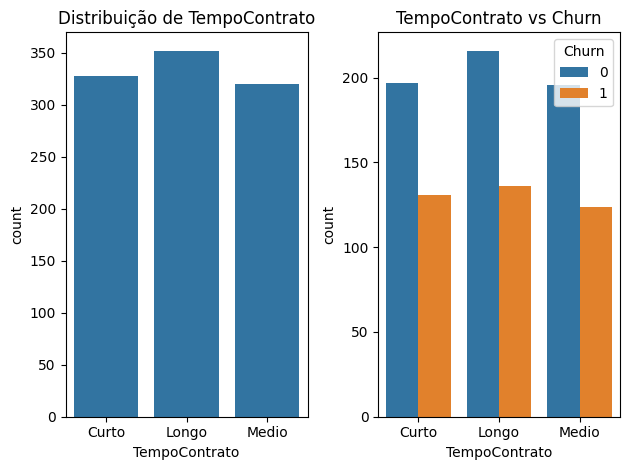

In [11]:
grafico_categorica(df_churn, 'TempoContrato')

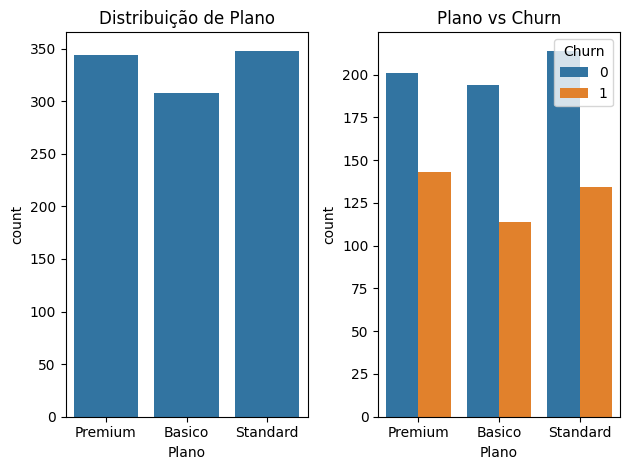

In [12]:
grafico_categorica(df_churn, 'Plano')

Baseado na análise exploratória, nenhuma variáve será removida.

## Divisão em Dados de Treino e Teste

In [13]:
def split_dataset(data, target_column, test_size, random_state = 29):
    """
    Divide o dataset em conjuntos de treino e teste.

    Parâmetros:
    - data (DataFrame): O DataFrame completo.
    - target_column (str): O nome da coluna alvo (target).
    - test_size (float): A proporção do conjunto de teste.
    - random_state (int): Seed para a geração de números aleatórios (padrão é 29).

    Retorna:
    - X_train (DataFrame): Conjunto de treino para as variáveis independentes.
    - X_test (DataFrame): Conjunto de teste para as variáveis independentes.
    - y_train (Series): Conjunto de treino para a variável alvo.
    - y_test (Series): Conjunto de teste para a variável alvo.
    """

    # REmove coluna alvo do DataFrame
    X = data.drop(target_column, axis = 1)
    
    # Dados de saída (target)
    y = data[target_column]
    
    # Divisão em treino e teste
    X_train, X_test, y_train, y_test = train_test_split(X, 
                                                        y, 
                                                        test_size = test_size, 
                                                        random_state = random_state)

    return X_train, X_test, y_train, y_test

In [14]:
X_train, X_test, y_train, y_test = split_dataset(df_churn, 'Churn', test_size = 0.3)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((700, 6), (300, 6), (700,), (300,))

## Pré-processamento dos Dados

O pré-processamento, especialmente a aplicação de encoding e a normalização de dados, deve idealmente ser feito **após a divisão do dataset em conjuntos de treino e teste**. Isso evita o vazamento de informações do conjunto de testes para o conjunto de treino, o que pode acontecer se o pré-processamento for feito antes da divisão.

In [15]:
df_churn.head()

,Idade,UsoMensal,Plano,SatisfacaoCliente,TempoContrato,ValorMensal,Churn
0,56,52,Premium,1,Curto,75.48,0
1,69,65,Basico,4,Curto,79.25,0
2,46,76,Standard,3,Longo,183.56,0
3,32,42,Basico,2,Longo,162.50,0
4,60,74,Standard,2,Longo,186.23,1


In [16]:
# Selecionano as variáveis categóricas
categorical_features = X_train.select_dtypes(include = ['object']).columns
categorical_features

Index(['Plano', 'TempoContrato'], dtype='object')

## One-Hot Encoding

O One-Hot Encoding é uma técnica para transformar variáveis categóricas (variáveis com valores em texto ou categorias) em uma forma que um modelo de Machine Learning consiga entender, ou seja, em valores numéricos binários.


In [17]:
encoder = OneHotEncoder(sparse_output = False)

In [18]:
X_train_encoded = pd.DataFrame(encoder.fit_transform(X_train[categorical_features]))
X_test_encoded = pd.DataFrame(encoder.transform(X_test[categorical_features]))

X_train_encoded.head(2)

,0,1,2,3,4,5
0,0.0,1.0,0.0,0.0,1.0,0.0
1,1.0,0.0,0.0,0.0,1.0,0.0


In [19]:
X_train_encoded.columns = encoder.get_feature_names_out(categorical_features)
X_test_encoded.columns = encoder.get_feature_names_out(categorical_features)

# Removendo as colunas categóricas originais e adicionando as codificadas
X_train_preprocessed = X_train.drop(categorical_features, axis = 1).reset_index(drop = True)
X_train_preprocessed = pd.concat([X_train_preprocessed, X_train_encoded], axis = 1)

X_test_preprocessed = X_test.drop(categorical_features, axis = 1).reset_index(drop = True)
X_test_preprocessed = pd.concat([X_test_preprocessed, X_test_encoded], axis = 1)

X_train_preprocessed.head()


,Idade,UsoMensal,SatisfacaoCliente,ValorMensal,Plano_Basico,Plano_Premium,Plano_Standard,TempoContrato_Curto,TempoContrato_Longo,TempoContrato_Medio
0,56,3,4,153.36,0.0,1.0,0.0,0.0,1.0,0.0
1,45,25,5,136.68,1.0,0.0,0.0,0.0,1.0,0.0
2,66,58,1,150.96,0.0,0.0,1.0,0.0,0.0,1.0
3,47,55,1,131.21,1.0,0.0,0.0,0.0,0.0,1.0
4,48,22,1,151.35,0.0,0.0,1.0,1.0,0.0,0.0


> Toda e qualquer transformação nos dados de treino, deve ser aplicada nos dados de teste.

## StandardScaler

O StandardScaler é uma ferramenta do scikit-learn que padroniza os dados, ou seja, transforma as variáveis numéricas para que tenham:
Média igual a 0 e Desvio padrão igual a 1.
Essa padronização é chamada de **normalização Z-score**.


In [20]:
# Variáveis numéricas
numeric_cols = X_train_preprocessed.select_dtypes(include = ['int64', 'float64']).columns

# Criando o StandardScaler
scaler = StandardScaler()

In [21]:
# Aplicando o StandardScaler às variáveis numéricas
X_train_preprocessed[numeric_cols] = scaler.fit_transform(X_train_preprocessed[numeric_cols])
X_test_preprocessed[numeric_cols] = scaler.transform(X_test_preprocessed[numeric_cols])

X_train_preprocessed.head()

,Idade,UsoMensal,SatisfacaoCliente,ValorMensal,Plano_Basico,Plano_Premium,Plano_Standard,TempoContrato_Curto,TempoContrato_Longo,TempoContrato_Medio
0,0.587564,-1.600748,0.711697,0.702722,-0.650203,1.367060,-0.740724,-0.681495,1.354256,-0.701810
1,-0.087696,-0.845909,1.423394,0.312207,1.537981,-0.731497,-0.740724,-0.681495,1.354256,-0.701810
2,1.201436,0.286348,-1.423394,0.646533,-0.650203,-0.731497,1.350030,-0.681495,-0.738413,1.424887
3,0.035078,0.183416,-1.423394,0.184143,1.537981,-0.731497,-0.740724,-0.681495,-0.738413,1.424887
4,0.096466,-0.948842,-1.423394,0.655663,-0.650203,-0.731497,1.350030,1.467363,-0.738413,-0.701810


## Modelagem

In [22]:
modelo_v1 = RandomForestClassifier(random_state = 29)

In [23]:
modelo_v1.fit(X_train_preprocessed, y_train)
y_pred = modelo_v1.predict(X_test_preprocessed)

In [24]:
accuracy =  accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

accuracy

0.8

In [25]:
print(classification_rep)

              precision    recall  f1-score   support

           0       0.87      0.81      0.84       194
           1       0.69      0.77      0.73       106

    accuracy                           0.80       300
   macro avg       0.78      0.79      0.79       300
weighted avg       0.81      0.80      0.80       300



## Uso de Validação Cruzada

Estes resultados fornecem uma visão mais robusta do desempenho do modelo, pois a validação cruzada avalia a capacidade do modelo de generalizar para novos dados.Isso pode ser devido a características dos dados, como desbalanceamento de classes, ou à necessidade de um ajuste mais fino dos hiperparâmetros do modelo.

In [27]:
modelo_v2 = RandomForestClassifier(random_state = 29)

 A variação nas pontuações de acurácia entre os diferentes folds indica que o modelo pode se comportar de maneira inconsistente em diferentes subconjuntos dos dados. 


In [32]:
scores_cv = cross_val_score(modelo_v2, X_train_preprocessed, y_train, cv = 5)
scores_cv

array([0.73571429, 0.76428571, 0.75      , 0.72857143, 0.75714286])